In [20]:
import numpy as np
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import matching.glema.common.utils.io_utils as io_utils

In [16]:
log_dir = io_utils.get_abs_file_path(
    "training/runs/CPG_augm_large/CPG_augm_large_undirected_anchored_v1_2024-12-30T09-34/events.out.tfevents.1735547696.MBPM3.local.2800.0" )

# Create an EventAccumulator to load the event file
event_acc = EventAccumulator( log_dir )
event_acc.Reload()

print( "Available tags:", event_acc.Tags()[ 'scalars' ] )

Available tags: ['batch/loss', 'batch/acc', 'train/loss', 'train/roc', 'train/acc', 'test/loss', 'test/roc', 'test/acc', 'time/train', 'time/test', 'time/total']


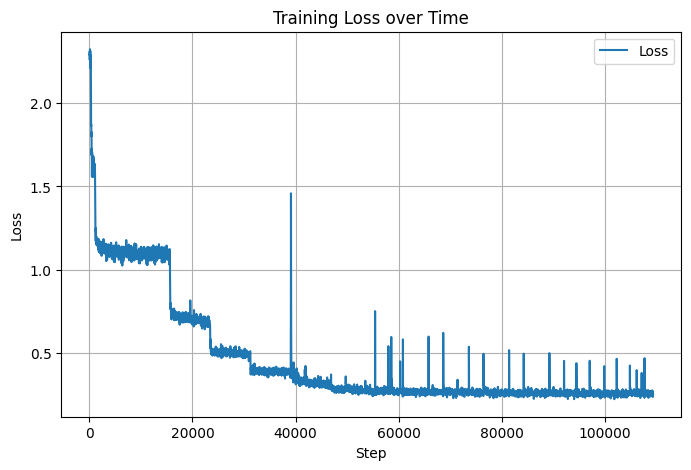

In [19]:
# Extract the scalar data for a specific tag, e.g., 'loss'
loss_events = event_acc.Scalars( 'batch/loss' )  # change 'loss' to your specific tag if different

# Extract steps and corresponding values
steps = [ event.step for event in loss_events ]
loss_values = [ event.value for event in loss_events ]

# Plot the data using matplotlib
plt.figure( figsize=(8, 5) )
plt.plot( steps, loss_values, label='Loss' )
plt.xlabel( 'Step' )
plt.ylabel( 'Loss' )
plt.title( 'Training Loss over Time' )
plt.legend()
plt.grid( True )
plt.show()